# Installing the packages

In [1]:
!pip install transformers
!pip install -q datasets seqeval
!pip install pyyaml==5.1
!pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
!apt-get install libleptonica-dev tesseract-ocr libtesseract-dev python3-pil tesseract-ocr-eng tesseract-ocr-script-latn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libleptonica-dev is already the newest version (1.79.0-1).
libtesseract-dev is already the newest version (4.1.1-2build2).
tesseract-ocr is already the newest version (4.1.1-2build2).
tesseract-ocr-eng is already the newest version (1:4.00~git30-7274cfa-1).
tesseract-ocr-script-latn is already the newest version (1:4.00~git30-7274cfa-1).
pytho

# Importing libraries

In [2]:
import os
os.chdir('/content/drive/MyDrive/unstop_competition/')

In [3]:
from ast import arg
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer,AutoTokenizer
from transformers import LayoutLMv2FeatureExtractor, AutoTokenizer, LayoutLMv2Processor

from datasets import load_metric,load_from_disk
import os
import numpy as np
import torch
import warnings
import argparse
from PIL import Image, ImageDraw, ImageFont
import torch
import pytesseract



warnings.filterwarnings('ignore')

# Loading model and tokenizer for training

In [4]:
model = AutoModelForTokenClassification.from_pretrained("model/checkpoint-98")


In [5]:
feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=True) # set
tokenizer = AutoTokenizer.from_pretrained("model/checkpoint-98")
# cannot use from_pretrained since the processor is not saved in the base model
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

In [6]:
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

label2color = {
'B-BILL_TO_ADDRESS' :"blue",
 'B-BILL_TO_NAME':"orange",
 'B-DUE_DATE':"green",
 'B-INVOICE_DATE':"green",
 'B-INVOICE_NUMBER':"pink",
 'B-PAYMENT_INFO':"magenta",
 'B-SHIP_TO_ADDRESS':"green",
 'B-SHIP_TO_NAME':"violet",
 'B-TOTAL_AMOUNT':"blue",
 'E-BILL_TO_ADDRESS':"red",
 'E-BILL_TO_NAME':"red",
 'E-DUE_DATE':"yellow",
 'E-TOTAL_AMOUNT':"blue",
 'E-INVOICE_NUMBER':"blue",
 'E-PAYMENT_INFO':"purple",
 'E-SHIP_TO_ADDRESS':"magenta",
 'E-SHIP_TO_NAME':"purple",
 'I-BILL_TO_ADDRESS':"violet",
 'I-BILL_TO_NAME':"purple",
 'I-DUE_DATE':"blue",
 'I-INVOICE_DATE':"yellow",
 'I-PAYMENT_INFO':"brown",
 'I-SHIP_TO_ADDRESS':"magenta",
 'I-SHIP_TO_NAME':"cyan",
 'I-TOTAL_AMOUNT':"orange",
 'O':"white",
 'S-BILL_TO_ADDRESS':"cyan",
 'S-BILL_TO_NAME':"yellow",
 'S-DUE_DATE':"red",
 'S-INVOICE_DATE':"violet",
 'S-INVOICE_NUMBER':"orange",
 'S-PAYMENT_INFO':"yellow",
 'S-SHIP_TO_ADDRESS':"cyan",
 'S-TOTAL_AMOUNT':"orange",
 'S-TOTAL_TAX_AMOUNT':"magenta",
 }

# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image

In [10]:
def run_inference(image, model=model, processor=processor, output_image=True):
  '''Takes image path as input and returns the image with labels in it'''
    # create model input
    encoding = processor(image, return_tensors="pt")
    # del encoding["pixel_values"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels

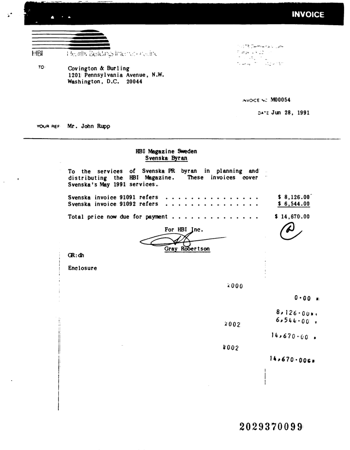

In [18]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("data/test/630.jpeg")
image = image.convert("RGB")
image.resize((350,450))
     

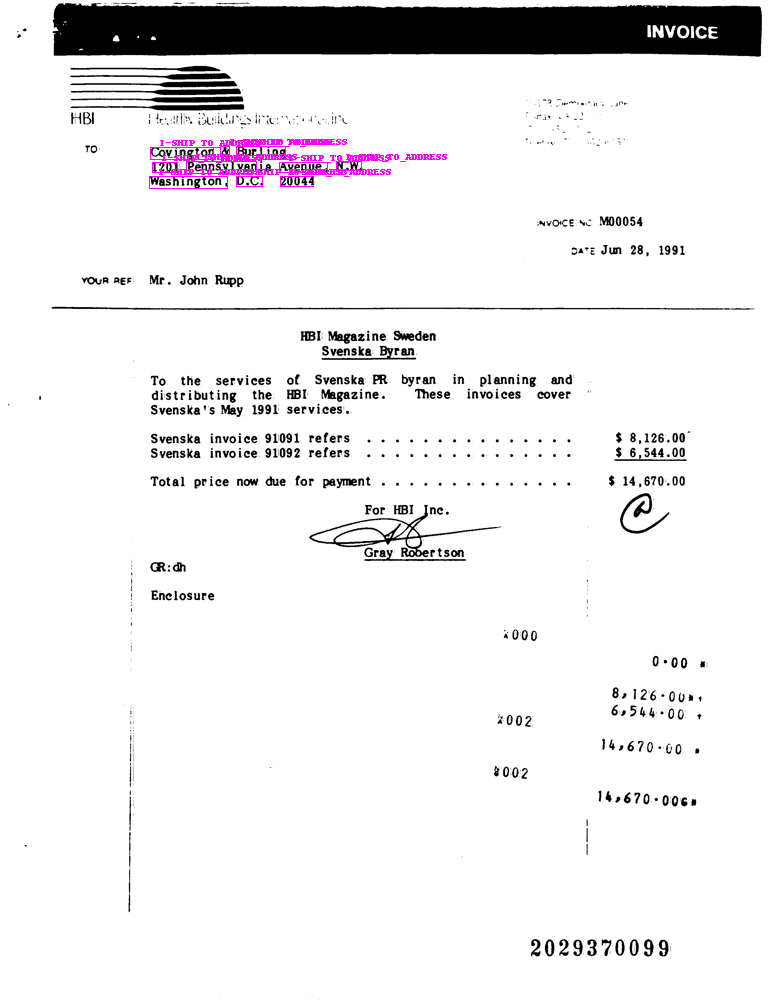

In [19]:
run_inference(image)
# Below image shows the image with label

the performance is not that good because number on points for training is very less .for seeing some apprpraite results we need atleast 100 of points for training